#Setup e imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

from scipy.stats import skew
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from yellowbrick.regressor import PredictionError

#Carregando os dados

In [ ]:
data_2006_2010 = pd.read_csv('/content/drive/MyDrive/ML/'+\
                   'previsaoVotacaoDeputados/eleicoes_2006_a_2010.csv')

data_2014 = pd.read_csv('/content/drive/MyDrive/ML/'+\
                        'previsaoVotacaoDeputados/eleicoes_2014.csv')

#Analisando e preparando os dados

###Descrição das colunas

In [ ]:
variables_desc = '''
"sequencial_candidato" :(character) id do candidato

"nome": (character)

"uf": (character)

"partido": (character)

"quantidade_doacoes": (integer)

"quantidade_doadores": (integer) número de doadores diferentes

"total_receita": (double) soma em R$ das doações

"media_receita": (double) média das doações

"recursos_de_outros_candidatos/comites": (double) quantia em R$ das doações provenientes de outros candidatos ou comite partidário

"recursos_de_pessoas_fisicas": (double) quantia em R$ das doações provenientes de outros CPFs

"recursos_de_pessoas_juridicas": (double) quantia em R$ das doações provenientes de outros CNPJ

"recursos_proprios": (double) quantia em R$ das doações provenientes do próprio candidato

"recursos_de_partido_politico": (double) quantia em R$ das doações provenientes do partido político do candidato

"votos": (integer) variável alvo. Se refere ao número de votos na campanha de 2006 e 2010

"quantidade_despesas": (integer)

"quantidade_fornecedores": (integer) número de fornecedores/despesas diferentes

"total_despesa": (double) soma em R$ das despesas de campanha

"media_despesa": (double) média das despesas de campanha

"cargo": (character)

"Sexo":  (character)

"grau": (character) grau de instrução do candidato

"estado_civil": (character)

"ocupacao": (character) ocupação do candidato
'''

In [ ]:
variables_df = pd.DataFrame(columns=['Variable', 'Description', 'Type'])

variables_desc_line = [var_desc for var_desc in
                       variables_desc.split('\n') if var_desc]

for item in variables_desc_line:
  variables_df = variables_df.append({
      'Variable': re.findall('\"[\s\S]*\"', item)[0].replace('\"', ''),

      'Description': re.sub('\([\s\S]*\)', '', 
                            item.split(":")[-1]),

      'Type': re.sub('[\(\)]', '', re.findall('\([\s\S]*\)', item)[0])\
        .capitalize()
  }, ignore_index=True)

variables_df

,Variable,Description,Type
0,sequencial_candidato,id do candidato,Character
1,nome,,Character
2,uf,,Character
3,partido,,Character
4,quantidade_doacoes,,Integer
5,quantidade_doadores,número de doadores diferentes,Integer
6,total_receita,soma em R$ das doações,Double
7,media_receita,média das doações,Double
8,recursos_de_outros_candidatos/comites,quantia em R$ das doações provenientes de ou...,Double
9,recursos_de_pessoas_fisicas,quantia em R$ das doações provenientes de ou...,Double


##Vamos observar as colunas que possuem valores nulos e quantos exemplos desses cada uma contém.

In [ ]:
null_data = data_2006_2010.isnull().sum()
null_data[null_data > 0]

total_receita                             161
media_receita                             161
recursos_de_outros_candidatos/comites    2390
recursos_de_pessoas_fisicas              2683
recursos_de_pessoas_juridicas            3976
recursos_proprios                        2388
dtype: int64

##Para as colunas referentes aos recursos, podemos trocar os valores ausentes pela média da própria coluna.


In [ ]:
def fill_missing(data):
  data['recursos_de_outros_candidatos/comites'].fillna(
      data['recursos_de_outros_candidatos/comites'].mean(), inplace=True)

  data['recursos_de_pessoas_fisicas'].fillna(
      data['recursos_de_pessoas_fisicas'].mean(), inplace=True)

  data['recursos_de_pessoas_juridicas'].fillna(
      data['recursos_de_pessoas_juridicas'].mean(), inplace=True)

  data['recursos_proprios'].fillna(
      data['recursos_proprios'].mean(), inplace=True)
  return data

data_2006_2010 = fill_missing(data_2006_2010)


##Para as colunas 'total_receita' e 'media_receita' temos duas estratégias:

Para a primeira coluna, podemos trocar pela soma das colunas que apresentam recursos.

Para a segunda, podemos fazer a média dessas colunas relacionadas aos recursos.

In [ ]:
def fill_missing_receipt(data):
  data['total_receita'] = data.apply(
      lambda row: round(row['recursos_de_outros_candidatos/comites']+\
        row['recursos_de_pessoas_fisicas']+\
        row['recursos_de_pessoas_juridicas']+\
        row['recursos_proprios'], 2) \
        if np.isnan(row['total_receita']) else row['total_receita'], axis=1)

  cols = ['recursos_de_outros_candidatos/comites',
  'recursos_de_pessoas_fisicas',
  'recursos_de_pessoas_juridicas',
  'recursos_proprios']

  for index, row in data.copy().iterrows():
    count = 0

    for col in cols:
      if not np.isnan(row[col]) and row[col] > 0:
        count += 1

    value = round(row['total_receita'] / count, 2) if np.isnan(row['media_receita'])\
      else row['media_receita']

    data.at[index, 'media_receita'] = value
  return data

data_2006_2010 = fill_missing_receipt(data_2006_2010)

##Essas colunas não são desejadas:

A coluna 'nome' não é interessante para o modelo, pois pode trazer viés indesejável e é inviável realizar one-hot encoding.

A coluna 'cargo' não é interessante, pois todos possuem o mesmo valor 'DEPUTADO'.

A coluna 'sequencial_candidato' é apenas um identificador e deve ser removida.

A coluna 'ano' não trás valor semanticamente significante.

In [ ]:
def drop_unused(data):
  data = data.drop('ano', axis=1)
  data = data.drop('nome', axis=1)
  data = data.drop('sequencial_candidato', axis=1)
  data = data.drop('cargo', axis=1)
  return data

data_2006_2010 = drop_unused(data_2006_2010)

##Além disso, devemos aplicar alguma normalização para as colunas com valores numéricos.

In [ ]:
def plot_histograms(dataset, target_cols, columns=3, figure_size=(24, 16)):
    fig, axes = plt.subplots(int(len(target_cols) / columns) + 1, columns,
                             figsize=figure_size)

    axes = axes.flatten()

    for ax in axes[-1*(len(axes) - len(target_cols)):]:
        fig.delaxes(ax)

    for i in range(len(target_cols)):

        sns.kdeplot(dataset[target_cols[i]].values, ax=axes[i])

        axes[i].title.set_text(f'{target_cols[i]} distribution')
    plt.show()

In [ ]:
numeric_cols = data_2006_2010.select_dtypes([np.number]).columns

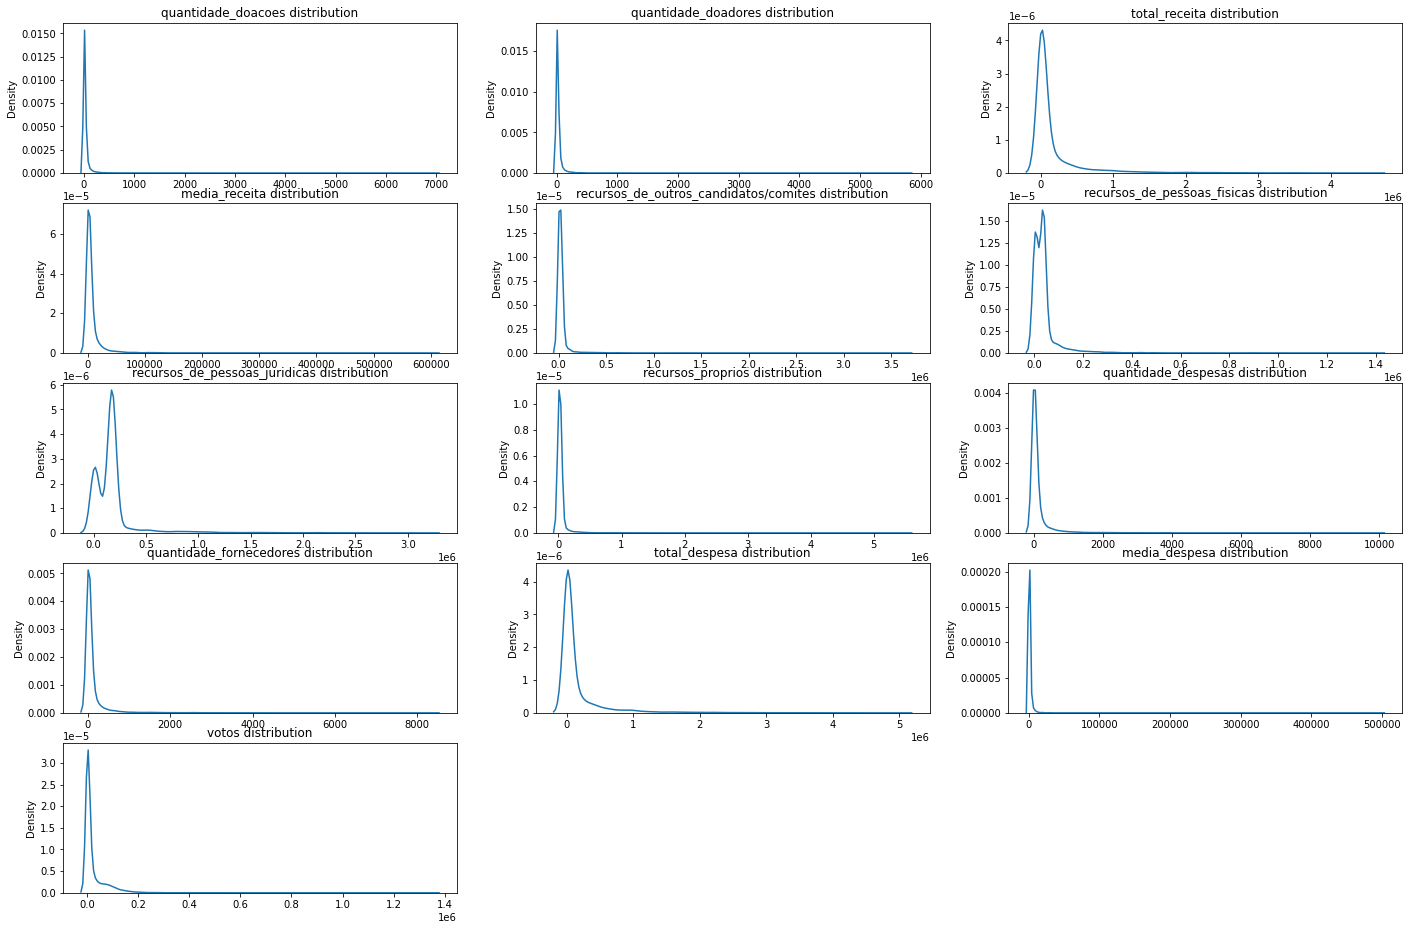

In [ ]:
plot_histograms(data_2006_2010, numeric_cols)

Observamos que as variáveis com valor numérico não apresentam distribuição normal, podemos aplicar algumas técnicas para normalizar.

Isso deve melhorar a precisão dos modelos de regressão.

In [ ]:
def apply_log(data):
  numeric_features = data.dtypes[data.dtypes != "object"].index

  data[numeric_features] = np.log1p(data[numeric_features])
  return data

data_2006_2010 = apply_log(data_2006_2010)

In [ ]:
def normalize_data(data):
  numeric_features = data.dtypes[data.dtypes != "object"].index
  numeric_features = numeric_features.drop("votos", errors='ignore')
  categorical_features = data.dtypes[data.dtypes == "object"].index

  scaler = MinMaxScaler()
  data_normalized = scaler.fit_transform(data[numeric_features])

  data_normalized = pd.DataFrame(data_normalized, 
                                columns=data[numeric_features].columns)
  try:
    data_normalized = data_normalized.assign(votos = data["votos"].values)
  except:
    pass

  data = pd.concat([data_normalized,
                    data[categorical_features].reset_index()],
                    axis = 1, sort = False)
  return data

data_2006_2010 = normalize_data(data_2006_2010)

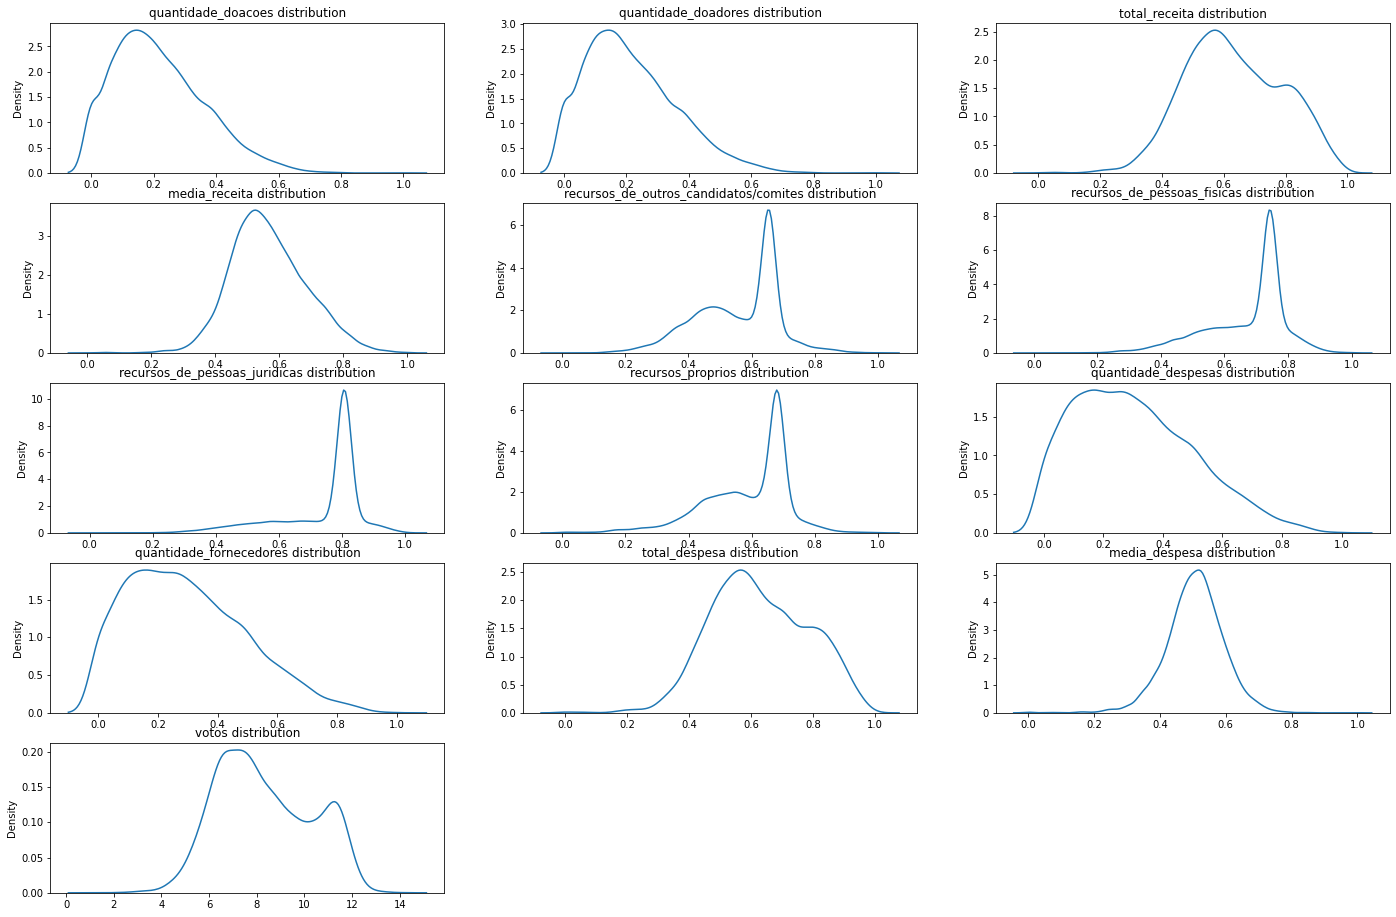

In [ ]:
plot_histograms(data_2006_2010, numeric_cols)

Agora as variáveis apresentam distribuição muito mais próxima de uma curva normal.

Além disso estão normalizadas com valor entre 0 e 1.

##Estas colunas merecem one-hot encoding

In [ ]:
shape_before_encoding = data_2006_2010.shape

In [ ]:
data_2006_2010['uf'].value_counts()

SP    1623
RJ     973
MG     811
RS     437
PR     404
BA     311
SC     244
PE     210
MA     190
PA     186
GO     175
CE     171
DF     143
ES     136
PB     125
MS     125
PI     122
RO     119
AP     106
AL     104
RR     104
MT     101
TO      97
AM      93
RN      76
SE      75
AC      69
Name: uf, dtype: int64

In [ ]:
data_2006_2010['partido'].value_counts()

PT         606
PMDB       574
PV         526
PDT        503
PSB        485
PSDB       477
PTB        403
PPS        329
PP         323
PSOL       299
PSC        276
PMN        258
PTC        245
PHS        218
PFL        180
PC do B    161
DEM        158
PSL        155
PL         154
PR         138
PT do B    127
PRTB       125
PRB        111
PSDC       109
PRP        107
PTN         91
PRONA       77
PAN         54
PSTU        41
PCB         14
PCO          6
Name: partido, dtype: int64

In [ ]:
data_2006_2010['sexo'].value_counts()

MASCULINO    6305
FEMININO     1025
Name: sexo, dtype: int64

In [ ]:
data_2006_2010['estado_civil'].value_counts()

CASADO(A)                    4704
SOLTEIRO(A)                  1452
DIVORCIADO(A)                 743
SEPARADO(A) JUDICIALMENTE     306
VIÚVO(A)                      125
Name: estado_civil, dtype: int64

In [ ]:
def encode_data(data):
  categorical_cols = ['uf', 'partido', 'sexo', 'estado_civil']
  categorical_cols_prefix = ['uf_', 'partido_', 'sexo_', 'estado_civil_']
  dum_df = pd.get_dummies(data, columns=categorical_cols,
                          prefix=categorical_cols_prefix)
  data = data.drop(categorical_cols, axis=1)
  data = data.merge(dum_df)
  return data

data_2006_2010 = encode_data(data_2006_2010)

In [ ]:
print(f'Columns before encoding: {shape_before_encoding[-1]}')
print(f'Columns after OneHot Encoding: {data_2006_2010.shape[-1]}')

Columns before encoding: 20
Columns after OneHot Encoding: 81


##A coluna que contem o grau de escolaridade  merece Ordinal Encoding

In [ ]:
data_2006_2010['grau'].value_counts()

SUPERIOR COMPLETO                4255
ENSINO MÉDIO COMPLETO            1435
SUPERIOR INCOMPLETO               803
ENSINO FUNDAMENTAL COMPLETO       432
ENSINO MÉDIO INCOMPLETO           192
ENSINO FUNDAMENTAL INCOMPLETO     183
LÊ E ESCREVE                       30
Name: grau, dtype: int64

In [ ]:
def apply_ordinal_encode(data):
  scholarship_categories = ['LÊ E ESCREVE',
                            'ENSINO FUNDAMENTAL INCOMPLETO',
                            'ENSINO FUNDAMENTAL COMPLETO',
                            'ENSINO MÉDIO INCOMPLETO',
                            'ENSINO MÉDIO COMPLETO',
                            'SUPERIOR INCOMPLETO',
                            'SUPERIOR COMPLETO']
  ordinal_encoder = OrdinalEncoder(categories=[scholarship_categories])

  data['grau'] = ordinal_encoder.fit_transform(data[['grau']])
  return data

data_2006_2010 = apply_ordinal_encode(data_2006_2010)

##Para a coluna ocupação, vamos destacar as ocupações relacionadas à cargos políticos e então realizar one-hot encoding

In [ ]:
print(f'Unique occupation examples: {len(data_2006_2010["ocupacao"].unique())}')

Unique occupation examples: 175


In [ ]:
def apply_occupation_encoding(data):
  political_occupations = ['Deputado','Senador','Governador','Presidente']
  political_occupations = list(map(lambda string: string.upper(),
                                  political_occupations))

  data['ocupacao'] = data['ocupacao']\
    .apply(lambda row: row if row in political_occupations else 'OUTRO')


  dum_df = pd.get_dummies(data, columns=['ocupacao'], prefix='ocupacao_')
  data = data.drop('ocupacao', axis=1)
  data = data.merge(dum_df)
  return data

data_2006_2010 = apply_occupation_encoding(data_2006_2010)

print(f'Columns after OneHot Encoding: {data_2006_2010.shape[-1]}')

Columns after OneHot Encoding: 83


#Separando os dados em treino e teste

In [ ]:
y = data_2006_2010['votos']
X_train, X_test, y_train, y_test = \
  train_test_split(data_2006_2010.loc[:, data_2006_2010.columns != 'votos'],
                   y, test_size=0.3, random_state=42)

#Ridge e Lasso

##Ridge

In [ ]:
def rmse_cv(model):
    score = cross_val_score(model, X_train, y_train,
                            scoring="neg_mean_squared_error", cv = 5)
        
    return np.sqrt(-1 * score)

In [ ]:
alphas = [0.001, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=a, random_state=42, max_iter=100000)).mean() for a in alphas]

Text(0, 0.5, 'rmse')

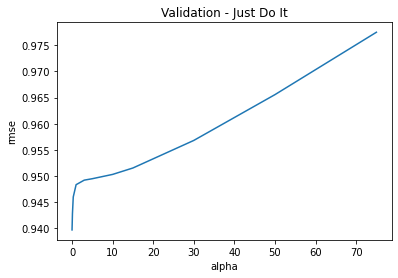

In [ ]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [ ]:
cv_ridge.min()

0.939711943450223

###Observa-se que para a regressão Ridge, o alpha que proporciona menor RMSE é alpha = 0.001, com RMSE de aproximadamente 0.9397.

###Vamos observar os resíduos para o modelo ridge

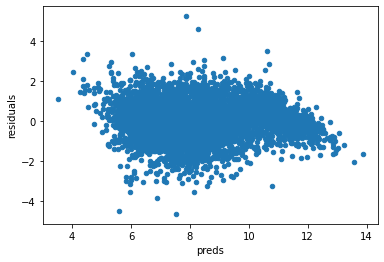

In [ ]:
ridge = Ridge(alpha=0.001, random_state=42, max_iter=100000)
model_ridge = ridge.fit(X_train, y_train)

preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Os resíduos não parecem ter nenhum padrão bem definido.

##Lasso

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.0001, 0.00001],
                      max_iter=100000,
                      random_state=42).fit(X_train, y_train)

In [ ]:
rmse_lasso = rmse_cv(model_lasso)

In [ ]:
rmse_lasso

array([0.95167312, 0.93992585, 0.93716153, 0.94538574, 0.9241487 ])

###Observa-se que para a regressão Lasso, o alpha que proporciona menor RMSE é alpha = 0.00001, com RMSE de aproximadamente 0.9241.

###Observa-se que o Lasso obteve RMSE bastante parecido com o obtido pelo Ridge, mas como ele faz seleção de atributos, vamos utilizá-lo para verificar a importância das variáveis.

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print(f'Lasso picked {sum(coef != 0)} variables '+\
      f'and eliminated the other {sum(coef == 0)} variables')

Lasso picked 78 variables and eliminated the other 4 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

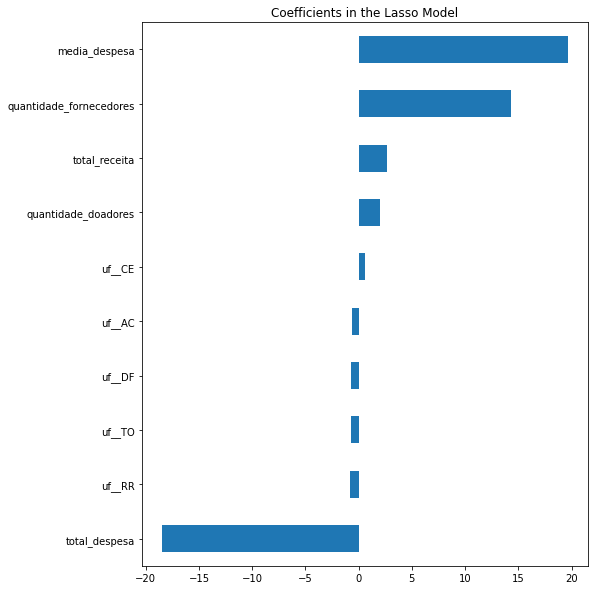

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(5),
                     coef.sort_values().tail(5)])

plt.figure(figsize=(8, 10))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

###Observa-se que o modelo está utilizando a **média de despesa** como a variável mais importante para prever sua quantidade de votos, depois a **quantidade de fornecedores**,o **total da receita** e a **quantidade de doadores**.

###Observando os resíduos

<Figure size 432x432 with 0 Axes>

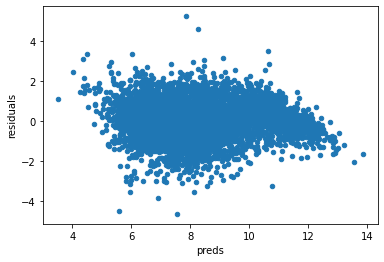

In [ ]:
plt.figure(figsize=(6, 6))

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Nota-se que não parece existir nenhum padrão nos resíduos.



#Random Forest

Vamos experimentar regressão não linear com Random Forest



In [ ]:
from sklearn.ensemble import RandomForestRegressor

depths = [2, 3, 5, 8, 13, 21, 34, 55, 89]
cv_rf = [rmse_cv(RandomForestRegressor(max_depth=d, random_state=42,
                                       n_estimators=200)).mean() 
            for d in depths]
       

Text(0, 0.5, 'RMSE')

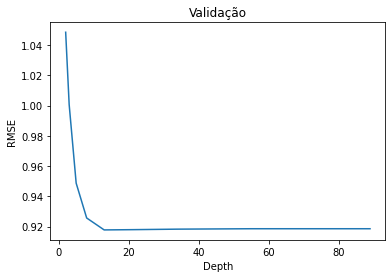

In [ ]:
cv_rf = pd.Series(cv_rf, index = depths)
cv_rf.plot(title = "Validação")
plt.xlabel("Depth")
plt.ylabel("RMSE")     

In [ ]:
cv_rf.min()

0.9178376946824519

In [ ]:
cv_rf.idxmin()

13

Pode-se observar que o RMSE decai ao longo das iterações. Atingindo mínimo(0.9178) quando **depth = 13**.

Vamos observar os resíduos





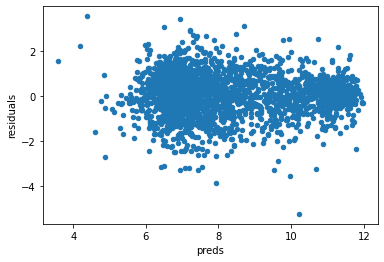

In [ ]:
rf = RandomForestRegressor(max_depth=13, random_state=42, n_estimators=200)
model_rf = rf.fit(X_train, y_train)

preds = pd.DataFrame({"preds":model_rf.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Nota-se que não parece existir nenhum padrão nos resíduos.

#KNN

Vamos experimentar regressão não paramétrica com KNN


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

ks = [1, 2, 3, 5, 8, 13, 21, 25, 34, 41, 55]
cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors=k)).mean() 
            for k in ks]

Text(0, 0.5, 'RMSE')

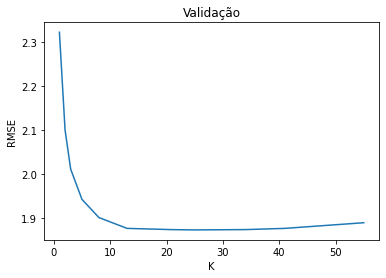

In [ ]:
cv_knn = pd.Series(cv_knn, index = ks)
cv_knn.plot(title = "Validação")
plt.xlabel("K")
plt.ylabel("RMSE")

In [ ]:
cv_knn.min()

1.8722076430833012

In [ ]:
cv_knn.idxmin()

25

Pode-se observar que o RMSE decai ao longo das iterações. Atingindo mínimo(1.87) quando **k = 25**.

Vamos observar os resíduos

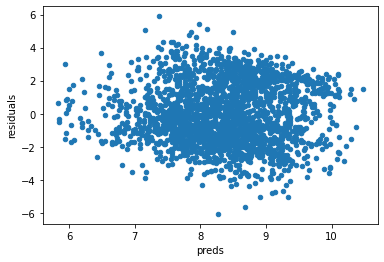

In [ ]:
knn = KNeighborsRegressor(n_neighbors=25)
model_knn = knn.fit(X_train, y_train)

preds = pd.DataFrame({"preds":model_knn.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Nota-se, mais uma vez, que não parece existir nenhum padrão nos resíduos. Porém os resíduos parecem se concentrar em valores mais altos. 

#Resultados para os dados de 2006 e 2010

In [ ]:
ridge_pred = model_ridge.predict(X_test)
lasso_pred = model_lasso.predict(X_test)
knn_pred = model_knn.predict(X_test)
rf_pred = model_rf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

ridge_rmse = mean_squared_error(y_test, ridge_pred, squared=False)
ridge_r2 = r2_score(y_test, ridge_pred)

lasso_rmse = mean_squared_error(y_test, lasso_pred, squared=False)
lasso_r2 = r2_score(y_test, lasso_pred)

knn_rmse = mean_squared_error(y_test, knn_pred, squared=False)
knn_r2 = r2_score(y_test, knn_pred)

rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
rf_r2 = r2_score(y_test, rf_pred)

print(f'Ridge             - RMSE: {ridge_rmse:.2f}  - Rsquared: {ridge_r2:.2f}')
print(f'Lasso             - RMSE: {lasso_rmse:.2f}  - Rsquared: {lasso_r2:.2f}')
print(f'KNN               - RMSE: {knn_rmse:.2f}  - Rsquared: {knn_r2:.2f}')
print(f'Random Forest     - RMSE: {rf_rmse:.2f}  - Rsquared: {rf_r2:.2f}')

Ridge             - RMSE: 0.96  - Rsquared: 0.77
Lasso             - RMSE: 0.96  - Rsquared: 0.77
KNN               - RMSE: 1.84  - Rsquared: 0.15
Random Forest     - RMSE: 0.93  - Rsquared: 0.78


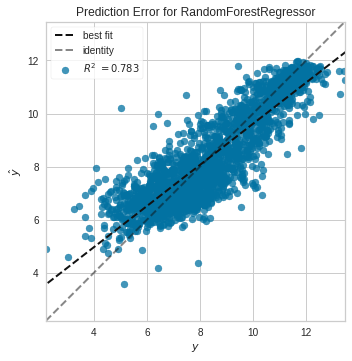

In [ ]:
visualizer = PredictionError(model_rf)
visualizer.score(X_test, y_test)
visualizer.show()

#Resultados para os dados da eleição 2014


In [ ]:
data_pipeline = [fill_missing,
                 fill_missing_receipt,
                 apply_log,
                 normalize_data,
                 drop_unused,
                 encode_data,
                 apply_ordinal_encode,
                 apply_occupation_encoding]

for step in data_pipeline:
  data_2014 = step(data_2014)

In [ ]:
Y_2014 = data_2014['votos']
X_train_2014, X_test_2014, y_train_2014, y_test_2014 = \
  train_test_split(data_2014.loc[:, data_2014.columns != 'votos'],
                   Y_2014, test_size=0.3, random_state=42)

In [ ]:
model_ridge_2014 = Ridge(alpha=0.001, random_state=42, max_iter=100000)\
  .fit(X_train_2014, y_train_2014)

model_lasso_2014 = Lasso(alpha=0.00001, random_state=42, max_iter=100000)\
  .fit(X_train_2014, y_train_2014)

model_knn_2014 = KNeighborsRegressor(n_neighbors=25)\
  .fit(X_train_2014, y_train_2014)

model_rf_2014 = RandomForestRegressor(max_depth=13, random_state=42,
                                      n_estimators=200)\
                                      .fit(X_train_2014, y_train_2014)

In [ ]:
ridge_pred_2014 = model_ridge_2014.predict(X_test_2014)
lasso_pred_2014 = model_lasso_2014.predict(X_test_2014)
knn_pred_2014 = model_knn_2014.predict(X_test_2014)
rf_pred_2014 = model_rf_2014.predict(X_test_2014)

In [ ]:
ridge_rmse = mean_squared_error(y_test_2014, ridge_pred_2014, squared=False)
ridge_r2 = r2_score(y_test_2014, ridge_pred_2014)

lasso_rmse = mean_squared_error(y_test_2014, lasso_pred_2014, squared=False)
lasso_r2 = r2_score(y_test_2014, lasso_pred_2014)

knn_rmse = mean_squared_error(y_test_2014, knn_pred_2014, squared=False)
knn_r2 = r2_score(y_test_2014, knn_pred_2014)

rf_rmse = mean_squared_error(y_test_2014, rf_pred_2014, squared=False)
rf_r2 = r2_score(y_test_2014, rf_pred_2014)

print(f'Ridge             - RMSE: {ridge_rmse:.2f}  - Rsquared: {ridge_r2:.2f}')
print(f'Lasso             - RMSE: {lasso_rmse:.2f}  - Rsquared: {lasso_r2:.2f}')
print(f'KNN               - RMSE: {knn_rmse:.2f}  - Rsquared: {knn_r2:.2f}')
print(f'Random Forest     - RMSE: {rf_rmse:.2f}  - Rsquared: {rf_r2:.2f}')

Ridge             - RMSE: 1.60  - Rsquared: 0.59
Lasso             - RMSE: 1.60  - Rsquared: 0.59
KNN               - RMSE: 2.37  - Rsquared: 0.10
Random Forest     - RMSE: 1.64  - Rsquared: 0.57


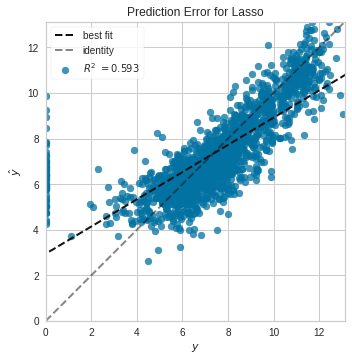

In [ ]:
visualizer = PredictionError(model_lasso_2014)
visualizer.score(X_test_2014, y_test_2014)
visualizer.show()

#Conclusão

Obtivemos resultados diferentes quando considerados apenas os dados de 2006 e 2010 para treino e teste. Anteriormente o modelo com menor erro era Random Forests. Já para os dados de 2014, o melhor modelo é a regressão com Lasso.

Apesar da diferença entre os erros dos modelos não ser tão grande, como o lasso tem menor RMSE (1.60) e maior R² (0.59), pode-se concluir que é o mais adequado para a predção dos votos dos deputados

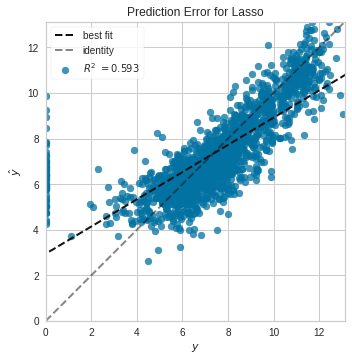

In [ ]:
visualizer = PredictionError(model_lasso_2014)
visualizer.score(X_test_2014, y_test_2014)
visualizer.show()